In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/aptos2019-blindness-detection
/kaggle/input/aptos2019-blindness-detection/train_images
/kaggle/input/aptos2019-blindness-detection/test_images


In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
 


In [4]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']
x, y = shuffle(x, y, random_state=SEED)

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=SEED)


# 원본 이미지

CPU times: user 4.44 s, sys: 291 ms, total: 4.73 s
Wall time: 4.81 s


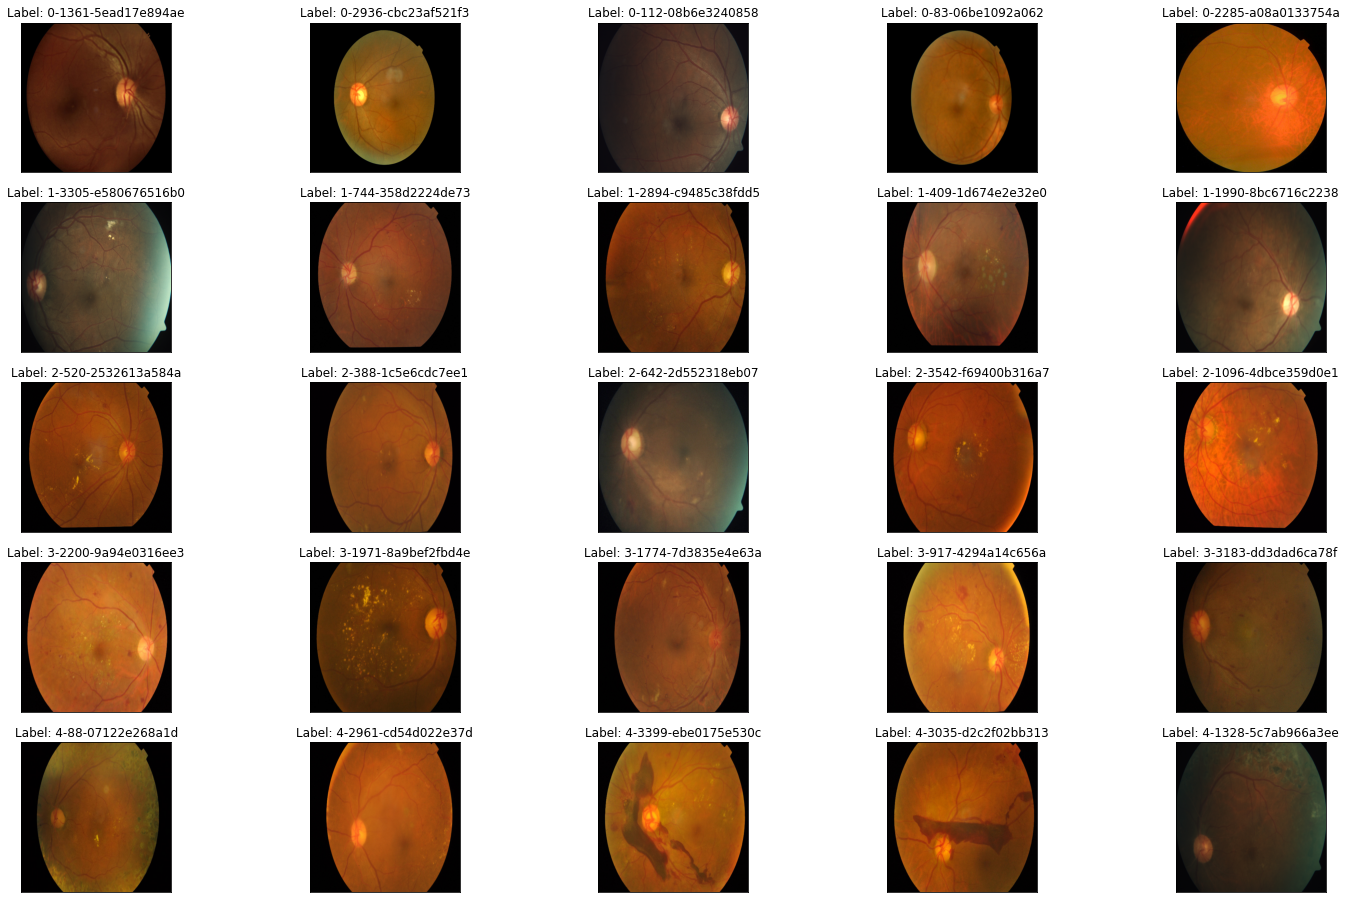

In [7]:
# 원본 이미지
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

# Gray Scale

CPU times: user 4.47 s, sys: 177 ms, total: 4.65 s
Wall time: 4.44 s


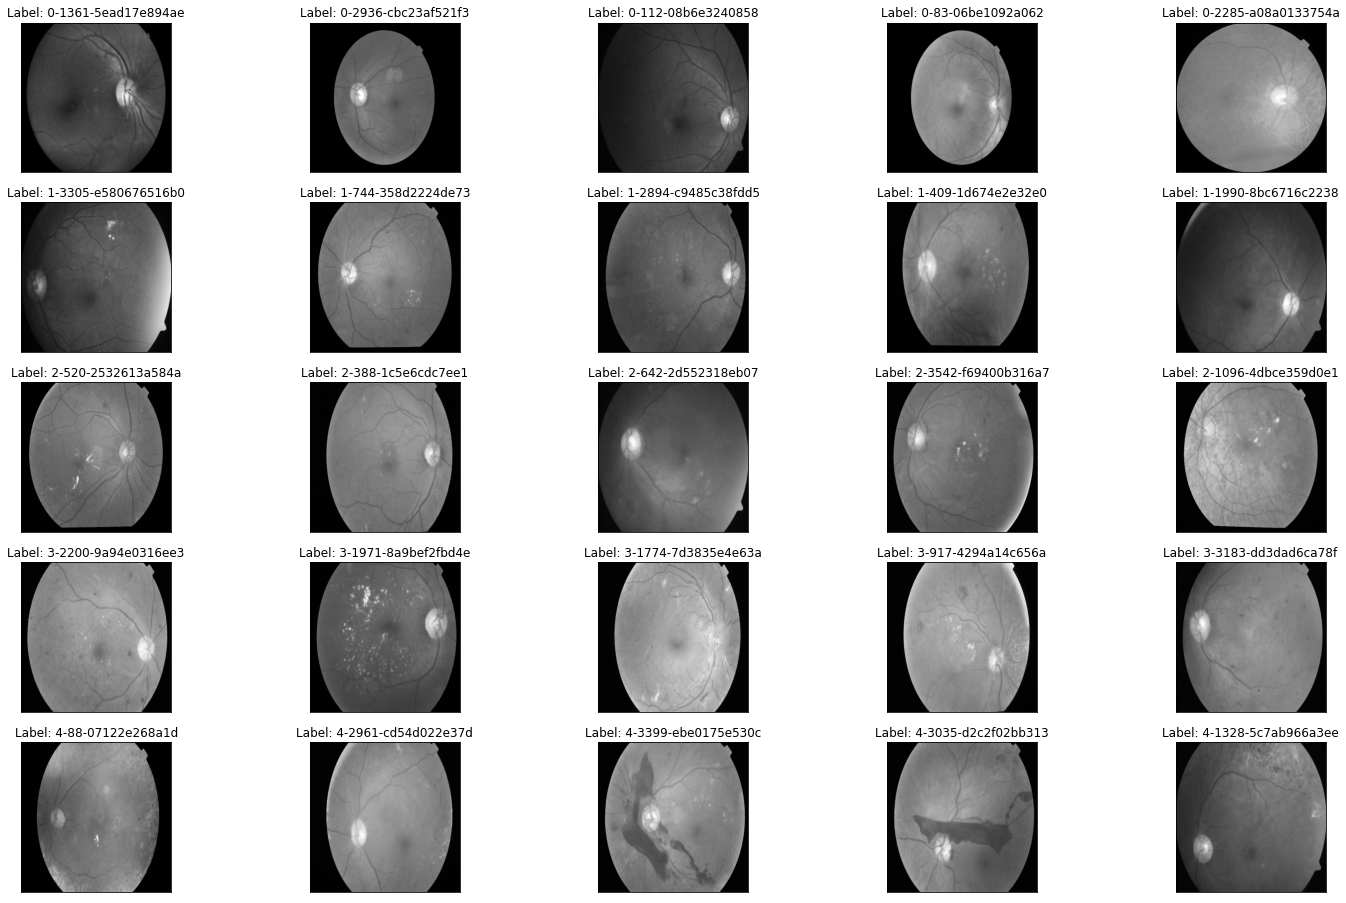

In [8]:
# gray scale
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

# **Ben Graham's preprocessing method.**

본 경진대회에서 1등을 차지한 Ben Graham은 이미지를 처리하는데 GaussianBlur를 사용하였다. 이를 적용해보기로 한다. 

CPU times: user 56.1 s, sys: 210 ms, total: 56.3 s
Wall time: 18.9 s


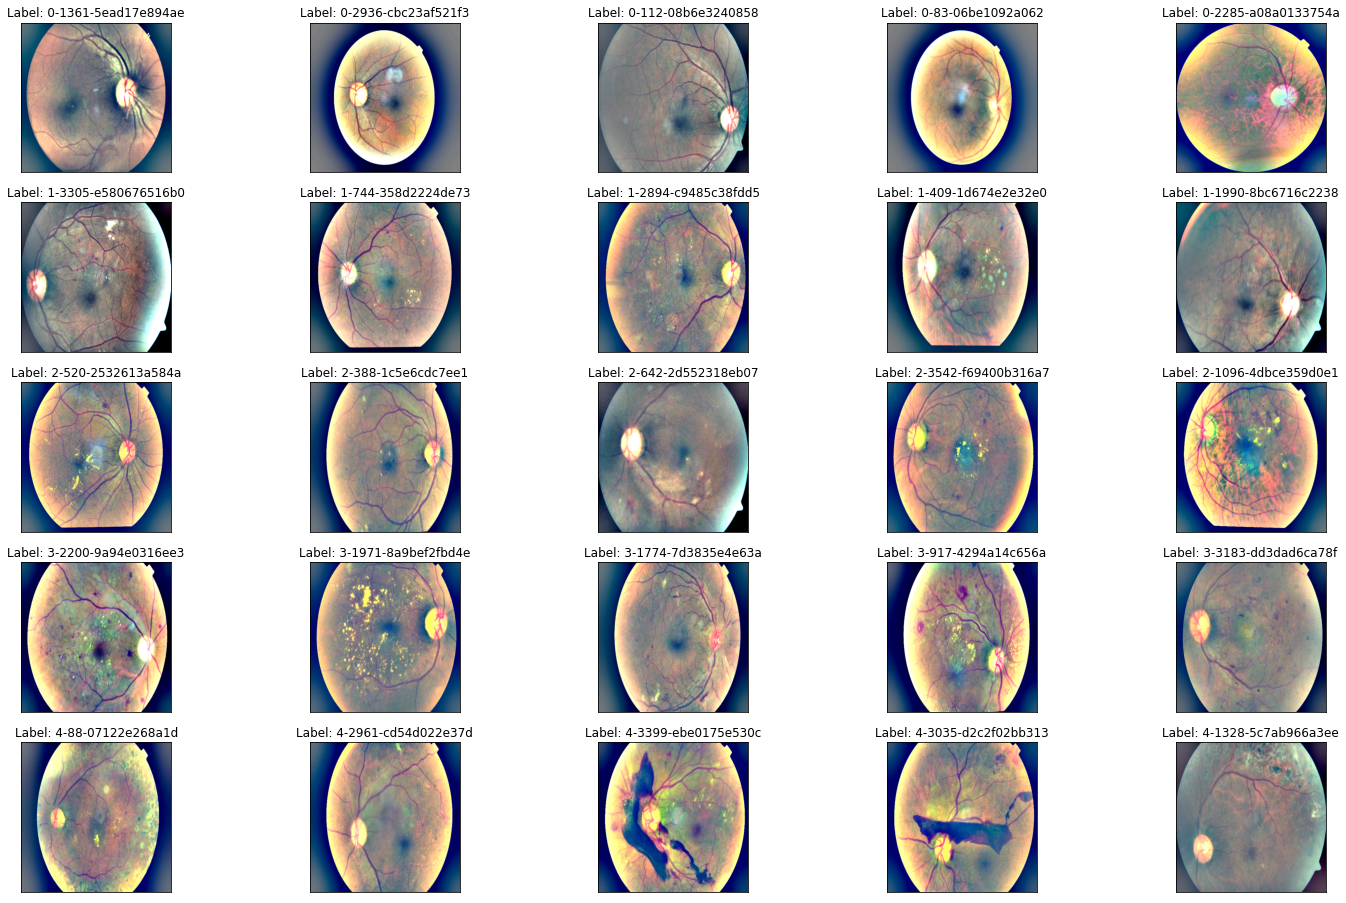

In [15]:
# Gaussian Blur
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

# Masking을 이용한 이미지 Cropping

image cropping
credit: https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy?scriptVersionId=20340219

In [9]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img


In [11]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

CPU times: user 29.7 s, sys: 612 ms, total: 30.3 s
Wall time: 15.3 s


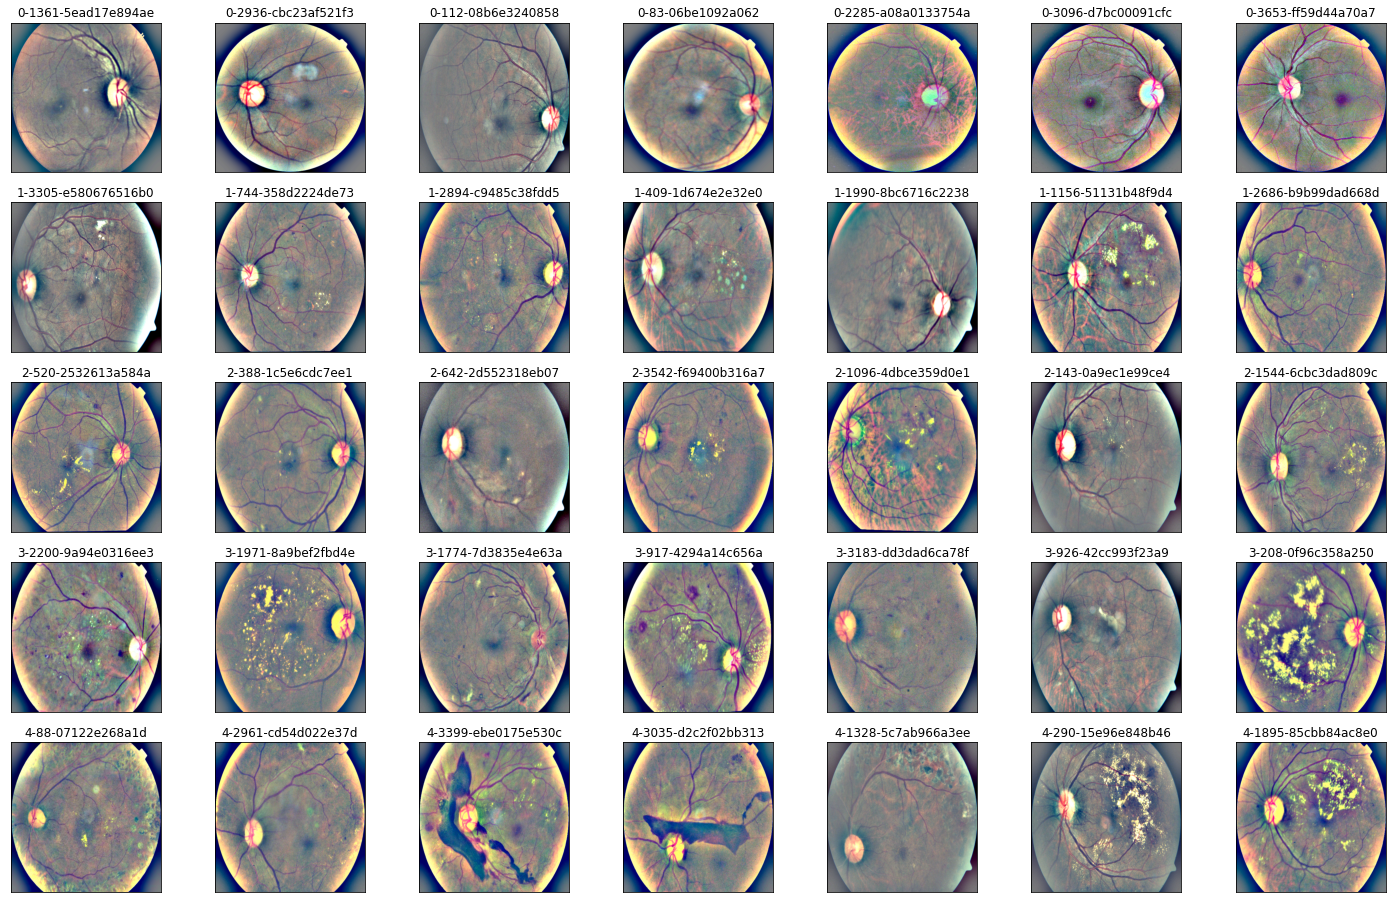

In [12]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

# Circle Cropping

Credit : https://www.kaggle.com/taindow/pre-processing-train-and-test-images

In [13]:
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

CPU times: user 1min 22s, sys: 785 ms, total: 1min 23s
Wall time: 32.1 s


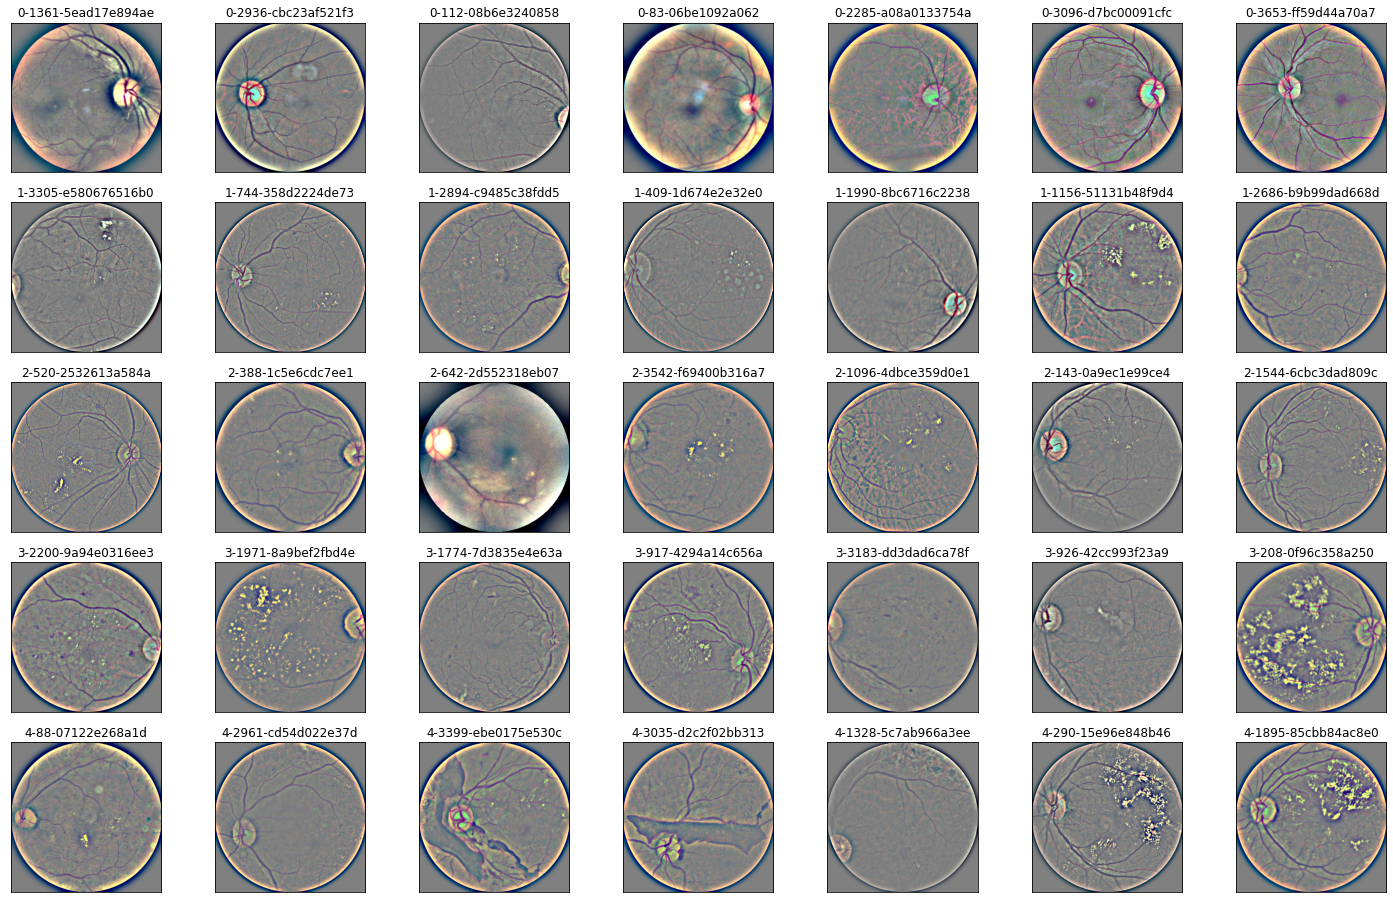

In [14]:
# circle crop
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = circle_crop(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )